In [43]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [44]:
use_google_colab = False

if use_google_colab==True:
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_project = '/content/drive/MyDrive/School/1. University/Year 4/Semester 2/APS360 - Applied Fundamentals of Deep Learning/Project/'
else:
    # When using on local machine. Folder 'split_data' must be in the same dir as this file.
    path_to_project=""
    
print(path_to_project)

In [45]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

mps


In [46]:
def count_images_and_percentage_with_partition(root):
    partitions = ['train', 'val', 'test']
    classes = ['Glass', 'Metal', 'Paper', 'Plastic']
    total_images = 0
    partition_totals = {}
    counts = {}

    # Count the images in each partition and class
    for partition in partitions:
        partition_counts = {}
        partition_total = 0
        for class_name in classes:
            class_path = os.path.join(root, 'split_data', partition, class_name)
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            count = len(image_files)
            partition_counts[class_name] = count
            partition_total += count
        counts[partition] = partition_counts
        partition_totals[partition] = partition_total
        total_images += partition_total

    # Print counts and percentages
    for partition, partition_counts in counts.items():
        print(f"'{partition}' partition: {partition_totals[partition]} images, {(partition_totals[partition] / total_images) * 100:.2f}% of total")
        for class_name, count in partition_counts.items():
            percentage = (count / partition_totals[partition]) * 100
            print(f" - {class_name}: {count} images, {percentage:.2f}% of partition")
        print()

    print(f"Total images across all partitions: {total_images}")

In [47]:
count_images_and_percentage_with_partition(path_to_project)

'train' partition: 2654 images, 69.97% of total
 - Glass: 649 images, 24.45% of partition
 - Metal: 683 images, 25.73% of partition
 - Paper: 658 images, 24.79% of partition
 - Plastic: 664 images, 25.02% of partition

'val' partition: 586 images, 15.45% of total
 - Glass: 143 images, 24.40% of partition
 - Metal: 151 images, 25.77% of partition
 - Paper: 145 images, 24.74% of partition
 - Plastic: 147 images, 25.09% of partition

'test' partition: 553 images, 14.58% of total
 - Glass: 136 images, 24.59% of partition
 - Metal: 142 images, 25.68% of partition
 - Paper: 137 images, 24.77% of partition
 - Plastic: 138 images, 24.95% of partition

Total images across all partitions: 3793


In [48]:
# Modified from Lab 3
def get_trash_data_loader(batch_size, img_dim):
    """
    Returns data loaders for the training, validation, and test datasets for the trash classification project.

    Args:
        batch_size: The number of samples per batch to load.
        img_dim: Size to resize the incoming images to. E.g., if using LargeNet128, img_dim=128

    Returns:
        train_loader: DataLoader for the training set
        val_loader: DataLoader for the validation set
        test_loader: DataLoader for the test set
    """
    # Transforms
    transform = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),  # Resize to img_dim x img_dim.
        transforms.RandomHorizontalFlip(),      # Random horizontal flip 50% chance
        transforms.RandomVerticalFlip(),        # Random vertical flip 50% chance
        transforms.RandomRotation(45),          # Random rotation by 45 degrees
        transforms.ToTensor(),                  # Convert images to tensor
    ])

    # Paths to the folders. Each class needs to have its own folder. Eg split_data/train/Glass
    train_dataset = datasets.ImageFolder(f'{path_to_project}split_data/train', transform=transform)
    val_dataset = datasets.ImageFolder(f'{path_to_project}split_data/val', transform=transform)
    test_dataset = datasets.ImageFolder(f'{path_to_project}split_data/test', transform=transform)

    # Create data loaders
    # https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
    num_workers = 2
    pin_memory = True if device == 'cuda' else False
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    
    return train_loader, val_loader, test_loader

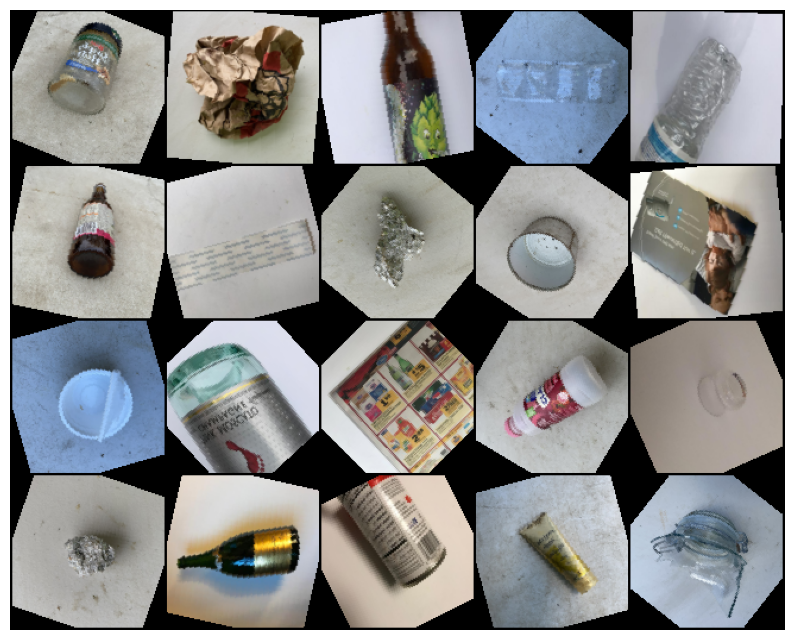

In [49]:
# Visualize a few sample images from the dataset 
train_loader_for_vis, _, _ = get_trash_data_loader(20, 128)

# Get a batch of training data
inputs, classes = next(iter(train_loader_for_vis))

# Make a 5x5 grid from the batch of images
out = torchvision.utils.make_grid(inputs, nrow=5)

plt.figure(figsize=(10,10))
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

In [50]:
class LargeNet256(nn.Module):
    def __init__(self):
        super(LargeNet256, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=10 * 30 * 30, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #convolution, relu activation, max pooling
        x = self.pool(F.relu(self.conv2(x))) #convolution, relu activation, max pooling
        x = x.view(-1, 10 * 30 * 30)
        x = F.relu(self.fc1(x)) #linear, relu activation
        x = self.fc2(x) #linear

        return x

In [51]:
class OptimizedCNN256(nn.Module):
    def __init__(self):
        super(OptimizedCNN256, self).__init__()
        
        # [input - kernel + 2*padding] / stride + 1

        # Conv #1
        # [3, 256, 256] -> [5, 252, 252]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=1, padding=0)
        
        # MaxPooling
        # [5, 252, 252] -> [5, 126, 126]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv #2
        # [5, 126, 126] -> [10, 122, 122]
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=5, stride=1, padding=0)

        # After the first layer: (256 - 5 + 1) / 1 = 252, then pooled: 252 / 2 = 126
        # After the second layer: (126 - 5 + 1) / 1 = 122, then pooled: 122 / 2 = 61
        self.num_flat_features = 10 * 61 * 61

        # First fully connected layer
        self.fc1 = nn.Linear(self.num_flat_features, 120)

        # Second fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # Output layer
        self.fc3 = nn.Linear(84, 4)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [52]:
class OptimizedCNN128(nn.Module):
    def __init__(self):
        super(OptimizedCNN128, self).__init__()
        
        # Conv #1: [3, 128, 128] -> [5, 124, 124]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=1, padding=0)
        
        # MaxPooling: [5, 124, 124] -> [5, 62, 62]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv #2: [5, 62, 62] -> [10, 58, 58]
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=5, stride=1, padding=0)

        # Adjusted for input size of 128x128
        self.num_flat_features = 10 * 29 * 29  # 8410

        # First fully connected layer
        self.fc1 = nn.Linear(self.num_flat_features, 120)

        # Second fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # Output layer
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [53]:
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedAlexNet, self).__init__()
        
        # Using the original AlexNet configuration with modifications
        self.features = nn.Sequential(
            # Convolutional Layer #1: Input (227x227x3) -> Output (55x55x96)
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            
            # Convolutional Layer #2: Input (55x55x96) -> Output (27x27x256)
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            
            # Convolutional Layer #3: Input (27x27x256) -> Output (13x13x384)
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Convolutional Layer #4: (skipped)
            # Convolutional Layer #5: (skipped)
            
            # Max Pooling Layer: Input (13x13x384) -> Output (6x6x384)
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            # Dropout Layer
            nn.Dropout(),
            
            # Fully Connected Layer #1: Input (6x6x384) -> Output (4096)
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            
            # Dropout Layer
            nn.Dropout(),
            
            # Fully Connected Layer #2: Input (4096) -> Output (4096)
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            # Fully Connected Layer #3: Input (4096) -> Output (num_classes)
            nn.Linear(4096, num_classes),
            # Note: No softmax here - use with CrossEntropyLoss
        )

    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        x = self.avgpool(x)
        
        # Flatten the features:
        x = torch.flatten(x, 1)
        
        # Classification
        x = self.classifier(x)
        
        return x

In [54]:
def plot_training_curve(config, train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation losses and accuracies."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [55]:
def train(model, train_loader, valid_loader, config):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    training_start_time = time.process_time()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) 

    best_valid_loss = float('inf')
    best_valid_acc = 0

    train_losses, valid_losses, train_accs, valid_accs = [], [], [], []

    for epoch in range(config['num_epochs']):
        start_of_epoch = time.process_time()
        
        model.train()  # Set model to training mode
        total_train_loss, total_train_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_correct += (predicted == labels).sum().item()

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate training accuracy
        train_accuracy = total_train_correct / (len(train_loader.dataset))
        train_accs.append(train_accuracy)

        # Set model to evaluation mode
        model.eval()
        total_valid_loss, total_valid_correct = 0, 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_valid_correct += (predicted == labels).sum().item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_accuracy = total_valid_correct / (len(valid_loader.dataset))
        valid_losses.append(avg_valid_loss)
        valid_accs.append(valid_accuracy)

        # Update best validation loss and accuracy
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            best_valid_acc = valid_accuracy

        time_elapsed = time.process_time() - start_of_epoch
        print(f"Epoch {epoch+1}/{config['num_epochs']} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_valid_loss:.4f} | Train Acc: {train_accuracy:.4f} | Validation Acc: {valid_accuracy:.4f} | Time: {time_elapsed:.4f}")

    # Training curve plot
    plot_training_curve(config, train_losses, valid_losses, train_accs, valid_accs)

    time_elapsed = time.process_time() - training_start_time
    print(f"Training complete in {time_elapsed:.2f}s")
    return best_valid_loss, best_valid_acc

Training OptimizedCNN128 model with config: {'learning_rate': 0.001, 'num_epochs': 120, 'batch_size': 128}
Epoch 1/120 | Train Loss: 2.1621 | Validation Loss: 1.4021 | Train Acc: 0.2698 | Validation Acc: 0.3089 | Time: 0.4336
Epoch 2/120 | Train Loss: 1.3126 | Validation Loss: 1.2496 | Train Acc: 0.3583 | Validation Acc: 0.4027 | Time: 0.2775
Epoch 3/120 | Train Loss: 1.2397 | Validation Loss: 1.2955 | Train Acc: 0.3998 | Validation Acc: 0.3874 | Time: 0.4557
Epoch 4/120 | Train Loss: 1.2399 | Validation Loss: 1.2173 | Train Acc: 0.4020 | Validation Acc: 0.3942 | Time: 0.3573
Epoch 5/120 | Train Loss: 1.2287 | Validation Loss: 1.2145 | Train Acc: 0.4050 | Validation Acc: 0.3754 | Time: 0.2772
Epoch 6/120 | Train Loss: 1.1909 | Validation Loss: 1.1925 | Train Acc: 0.4405 | Validation Acc: 0.4761 | Time: 0.4618
Epoch 7/120 | Train Loss: 1.1902 | Validation Loss: 1.1913 | Train Acc: 0.4424 | Validation Acc: 0.3959 | Time: 0.3199
Epoch 8/120 | Train Loss: 1.1935 | Validation Loss: 1.2346 |

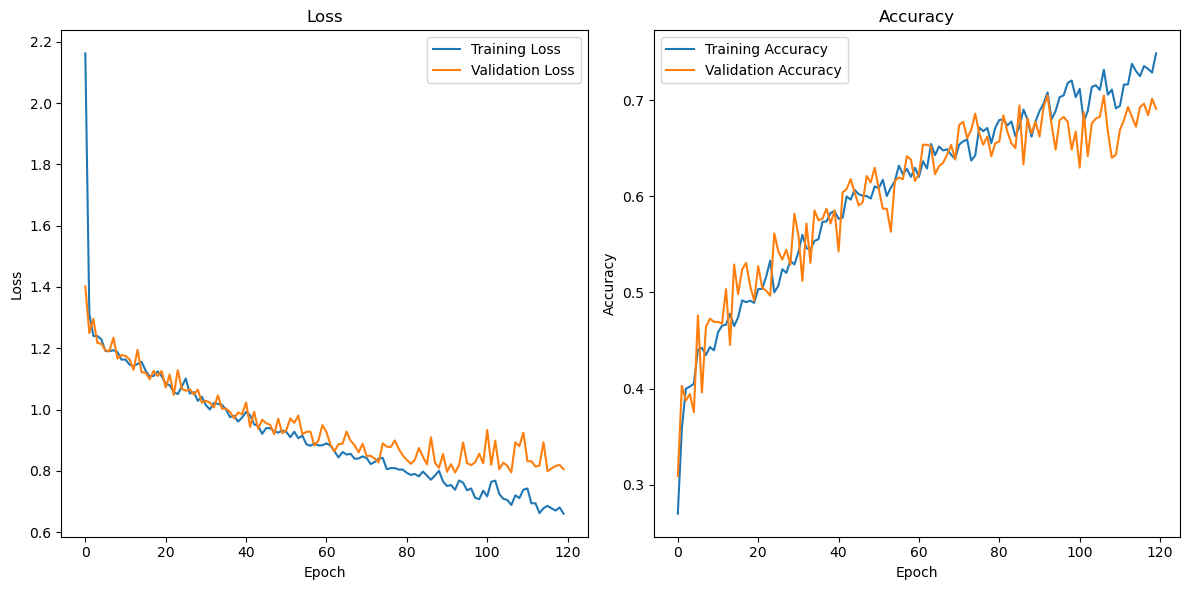

Training complete in 31.35s
Model saved to model_OptimizedCNN128_lr=0.001_epochs=120_batch=128.pth
Time elapsed: 32.032014000000004
Training OptimizedCNN128 model with config: {'learning_rate': 0.001, 'num_epochs': 200, 'batch_size': 128}
Epoch 1/200 | Train Loss: 1.9396 | Validation Loss: 1.4936 | Train Acc: 0.2589 | Validation Acc: 0.2491 | Time: 0.3056
Epoch 2/200 | Train Loss: 1.3619 | Validation Loss: 1.2994 | Train Acc: 0.3459 | Validation Acc: 0.3908 | Time: 0.2380
Epoch 3/200 | Train Loss: 1.2850 | Validation Loss: 1.2739 | Train Acc: 0.3742 | Validation Acc: 0.4215 | Time: 0.2199
Epoch 4/200 | Train Loss: 1.2237 | Validation Loss: 1.2047 | Train Acc: 0.4277 | Validation Acc: 0.3567 | Time: 0.2425
Epoch 5/200 | Train Loss: 1.1997 | Validation Loss: 1.2432 | Train Acc: 0.4363 | Validation Acc: 0.4642 | Time: 0.2311
Epoch 6/200 | Train Loss: 1.1854 | Validation Loss: 1.1765 | Train Acc: 0.4680 | Validation Acc: 0.4539 | Time: 0.3170
Epoch 7/200 | Train Loss: 1.1693 | Validation L

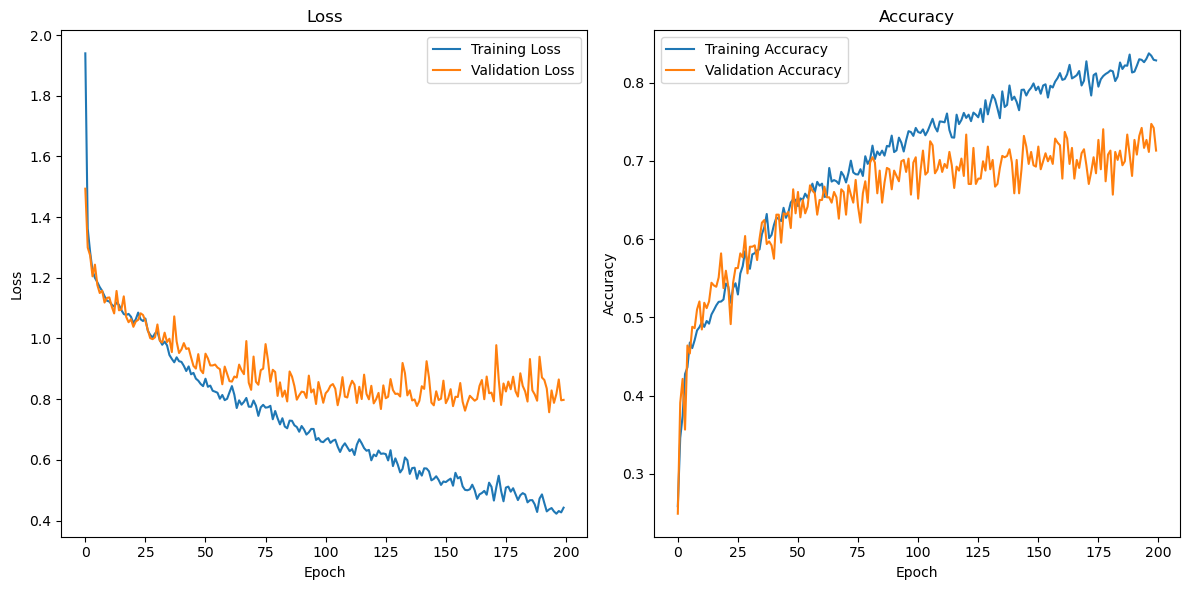

Training complete in 50.59s
Model saved to model_OptimizedCNN128_lr=0.001_epochs=200_batch=128.pth
Time elapsed: 51.297127
Training OptimizedCNN128 model with config: {'learning_rate': 0.0001, 'num_epochs': 120, 'batch_size': 128}
Epoch 1/120 | Train Loss: 3.6411 | Validation Loss: 2.5803 | Train Acc: 0.2366 | Validation Acc: 0.2577 | Time: 0.2429
Epoch 2/120 | Train Loss: 1.8515 | Validation Loss: 1.4288 | Train Acc: 0.2551 | Validation Acc: 0.2509 | Time: 0.2473
Epoch 3/120 | Train Loss: 1.4117 | Validation Loss: 1.3945 | Train Acc: 0.2570 | Validation Acc: 0.3362 | Time: 0.2545
Epoch 4/120 | Train Loss: 1.3781 | Validation Loss: 1.3792 | Train Acc: 0.3116 | Validation Acc: 0.2901 | Time: 0.2446
Epoch 5/120 | Train Loss: 1.3743 | Validation Loss: 1.3630 | Train Acc: 0.2913 | Validation Acc: 0.3413 | Time: 0.2683
Epoch 6/120 | Train Loss: 1.3646 | Validation Loss: 1.3558 | Train Acc: 0.3120 | Validation Acc: 0.3276 | Time: 0.2715
Epoch 7/120 | Train Loss: 1.3547 | Validation Loss: 1.3

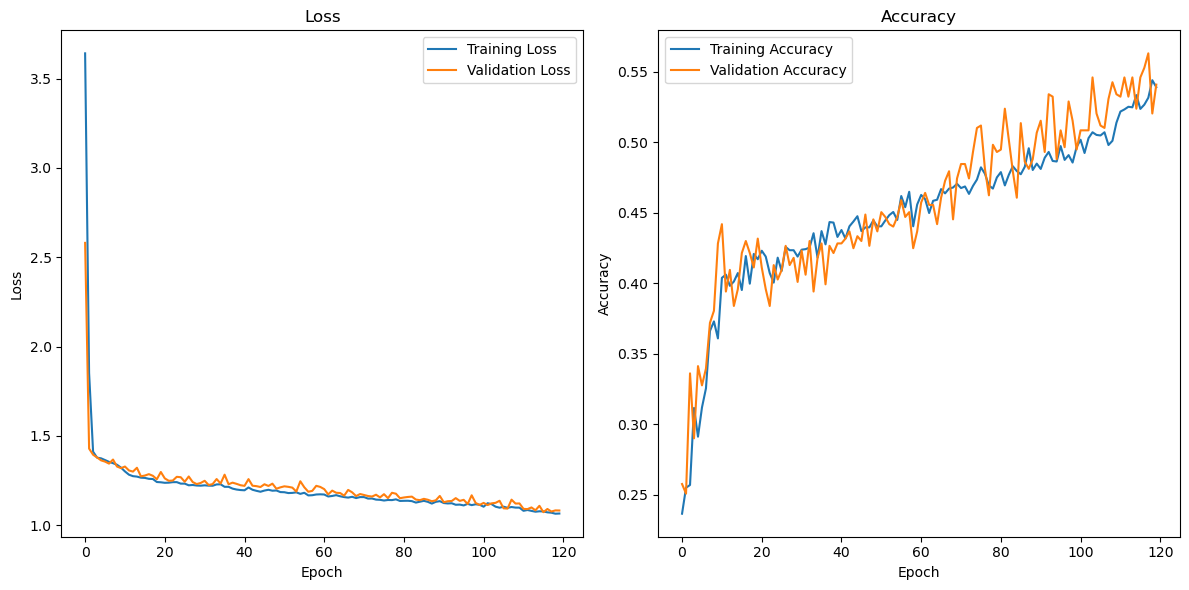

Training complete in 30.28s
Model saved to model_OptimizedCNN128_lr=0.0001_epochs=120_batch=128.pth
Time elapsed: 31.203506000000004
Training OptimizedCNN128 model with config: {'learning_rate': 1e-05, 'num_epochs': 120, 'batch_size': 128}
Epoch 1/120 | Train Loss: 4.3559 | Validation Loss: 4.3201 | Train Acc: 0.1379 | Validation Acc: 0.2628 | Time: 0.2597
Epoch 2/120 | Train Loss: 4.2849 | Validation Loss: 4.2385 | Train Acc: 0.2573 | Validation Acc: 0.2577 | Time: 0.2668
Epoch 3/120 | Train Loss: 4.1883 | Validation Loss: 4.1247 | Train Acc: 0.2573 | Validation Acc: 0.2577 | Time: 0.2500
Epoch 4/120 | Train Loss: 4.0586 | Validation Loss: 3.9736 | Train Acc: 0.2573 | Validation Acc: 0.2577 | Time: 0.2668
Epoch 5/120 | Train Loss: 3.8863 | Validation Loss: 3.7719 | Train Acc: 0.2573 | Validation Acc: 0.2577 | Time: 0.2041
Epoch 6/120 | Train Loss: 3.6575 | Validation Loss: 3.5095 | Train Acc: 0.2573 | Validation Acc: 0.2577 | Time: 0.2315
Epoch 7/120 | Train Loss: 3.3675 | Validation 

python(62140) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62141) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 14/120 | Train Loss: 1.4831 | Validation Loss: 1.4548 | Train Acc: 0.3704 | Validation Acc: 0.3686 | Time: 0.2551


python(62165) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62169) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62208) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62209) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 15/120 | Train Loss: 1.4456 | Validation Loss: 1.4266 | Train Acc: 0.3105 | Validation Acc: 0.3976 | Time: 0.2808


python(62237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62274) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 16/120 | Train Loss: 1.4207 | Validation Loss: 1.4087 | Train Acc: 0.3772 | Validation Acc: 0.3669 | Time: 0.2418


python(62304) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62305) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62398) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62399) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 17/120 | Train Loss: 1.4058 | Validation Loss: 1.3971 | Train Acc: 0.3527 | Validation Acc: 0.4113 | Time: 0.4046


python(62431) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 18/120 | Train Loss: 1.3951 | Validation Loss: 1.3877 | Train Acc: 0.3606 | Validation Acc: 0.3942 | Time: 0.2298


python(62496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 19/120 | Train Loss: 1.3866 | Validation Loss: 1.3814 | Train Acc: 0.3794 | Validation Acc: 0.3993 | Time: 0.2675


python(62574) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62575) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62612) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 20/120 | Train Loss: 1.3809 | Validation Loss: 1.3743 | Train Acc: 0.3531 | Validation Acc: 0.3908 | Time: 0.2314


python(62653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62704) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62705) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 21/120 | Train Loss: 1.3750 | Validation Loss: 1.3711 | Train Acc: 0.3794 | Validation Acc: 0.3908 | Time: 0.2213


python(62750) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62751) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 22/120 | Train Loss: 1.3696 | Validation Loss: 1.3648 | Train Acc: 0.3892 | Validation Acc: 0.3942 | Time: 0.2300


python(62837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 23/120 | Train Loss: 1.3656 | Validation Loss: 1.3638 | Train Acc: 0.3896 | Validation Acc: 0.3874 | Time: 0.2747


python(62915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62962) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 24/120 | Train Loss: 1.3626 | Validation Loss: 1.3569 | Train Acc: 0.3610 | Validation Acc: 0.3976 | Time: 0.2530


python(63023) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63024) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63065) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 25/120 | Train Loss: 1.3588 | Validation Loss: 1.3552 | Train Acc: 0.3866 | Validation Acc: 0.3771 | Time: 0.2941


python(63095) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63154) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63155) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 26/120 | Train Loss: 1.3564 | Validation Loss: 1.3526 | Train Acc: 0.3704 | Validation Acc: 0.3925 | Time: 0.2888


python(63189) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63190) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63226) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 27/120 | Train Loss: 1.3531 | Validation Loss: 1.3535 | Train Acc: 0.3700 | Validation Acc: 0.3976 | Time: 0.2288


python(63266) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63267) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63310) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63311) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 28/120 | Train Loss: 1.3508 | Validation Loss: 1.3490 | Train Acc: 0.3990 | Validation Acc: 0.3976 | Time: 0.2848


python(63343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63415) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 29/120 | Train Loss: 1.3479 | Validation Loss: 1.3462 | Train Acc: 0.3723 | Validation Acc: 0.4010 | Time: 0.2568


python(63454) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63455) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 30/120 | Train Loss: 1.3450 | Validation Loss: 1.3427 | Train Acc: 0.4050 | Validation Acc: 0.4027 | Time: 0.2264


python(63532) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63533) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 31/120 | Train Loss: 1.3423 | Validation Loss: 1.3404 | Train Acc: 0.3851 | Validation Acc: 0.3891 | Time: 0.3229


python(63649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63650) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 32/120 | Train Loss: 1.3402 | Validation Loss: 1.3394 | Train Acc: 0.3858 | Validation Acc: 0.4078 | Time: 0.2357


python(63720) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63721) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63757) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 33/120 | Train Loss: 1.3364 | Validation Loss: 1.3354 | Train Acc: 0.3791 | Validation Acc: 0.3925 | Time: 0.2501


python(63789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63846) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63847) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 34/120 | Train Loss: 1.3342 | Validation Loss: 1.3346 | Train Acc: 0.4039 | Validation Acc: 0.4113 | Time: 0.2442


python(63909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63972) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63973) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 35/120 | Train Loss: 1.3302 | Validation Loss: 1.3275 | Train Acc: 0.3794 | Validation Acc: 0.3942 | Time: 0.2716


python(64003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(64008) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(64054) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(64055) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 36/120 | Train Loss: 1.3276 | Validation Loss: 1.3289 | Train Acc: 0.3888 | Validation Acc: 0.4113 | Time: 0.2763


python(64117) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(64118) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(64166) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(64167) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/Users/hasaniqbal/anaconda3/envs/aps360-project/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/hasaniqbal/anaconda3/envs/aps360-project/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hasaniqbal/anaconda3/envs/aps360-project/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 277, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hasaniqbal/anaconda3/envs/aps360-project/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 144, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hasaniqbal/anaconda3/envs/aps360-project/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 121, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hasaniqbal/anaconda3/envs/aps360-project/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 172, in collate_tensor_fn
    storage = elem._typed_storage()._new_shared(numel, device=elem.device)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hasaniqbal/anaconda3/envs/aps360-project/lib/python3.12/site-packages/torch/storage.py", line 899, in _new_shared
    untyped_storage = torch.UntypedStorage._new_shared(size * self._element_size(), device=device)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hasaniqbal/anaconda3/envs/aps360-project/lib/python3.12/site-packages/torch/storage.py", line 257, in _new_shared
    return cls._new_using_filename_cpu(size)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Resource temporarily unavailable


In [58]:
hyperparameter_configs = [
    # {'learning_rate': 1e-3, 'num_epochs': 50, 'batch_size': 128}, # Done
    # {'learning_rate': 1e-3, 'num_epochs': 80, 'batch_size': 128}, # Done
    {'learning_rate': 1e-3, 'num_epochs': 120, 'batch_size': 128},
    {'learning_rate': 1e-3, 'num_epochs': 200, 'batch_size': 128},
    # {'learning_rate': 1e-4, 'num_epochs': 60, 'batch_size': 128},
    {'learning_rate': 1e-4, 'num_epochs': 120, 'batch_size': 128},
    # {'learning_rate': 1e-5, 'num_epochs': 60, 'batch_size': 128},
    {'learning_rate': 1e-5, 'num_epochs': 120, 'batch_size': 128},
    {'learning_rate': 1e-5, 'num_epochs': 200, 'batch_size': 128},
]

performance_tracking = []

for config in hyperparameter_configs:
    start = time.process_time()
    
    model = OptimizedCNN128().to(device)
    
    print(f"Training {model.__class__.__name__} model with config: {config}")

    train_loader, val_loader, test_loader = get_trash_data_loader(batch_size=config["batch_size"], img_dim=128)
    
    best_valid_loss, best_valid_acc = train(model, train_loader, val_loader, config)

    # Track the performance for each config
    performance_tracking.append({
        'config': config,
        'best_valid_acc': best_valid_acc,
        'best_valid_loss': best_valid_loss
    })

    # Save the model after training
    model_save_path = f"{path_to_project}model_{model.__class__.__name__}_lr={config['learning_rate']}_epochs={config['num_epochs']}_batch={config['batch_size']}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    print(f"Time elapsed: {time.process_time() - start}")

# Determine best performing model
best_performance = sorted(performance_tracking, key=lambda x: x['best_valid_loss'])[0]
print("Best performing model configuration:", best_performance['config'])122
print("With Validation Loss:", best_performance['best_valid_loss'], "and Validation Accuracy:", best_performance['best_valid_acc'])

In [ ]:
def load_model(model_class, model_path):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

In [ ]:
def predict_image(image_path, model, device, img_dim=128):
    """Predict the class for a single image."""
    transform = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),
        transforms.ToTensor(),
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

In [ ]:
from PIL import Image

model_path = f"{path_to_project}model_OptimizedLargeNet256_lr=0.001_epochs=60_batch=128.pth"
image_path = f"{path_to_project}split_data/test/Paper/Paper_8.jpg"

model = load_model(OptimizedCNN128, model_path)

predicted_class = predict_image(image_path, model, device)

# 0 = Glass, 1 = Metal, 2 = Paper, 3 = Plastic
print(f"Predicted class: {predicted_class}")